In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, jaccard_score


class ClassifierPipeline(object): 

    def __init__(self, classifier_dict):
        """
            Preprocessing should be done 
            Args: 
                dictionary of classifier, w its parameters
                number of cross-validation folds
        """
        self.classifier_dict = classifier_dict
    
    def fit(self, X, y, numfolds):
        """
            Fit k-fold cross-validated classifier, store model metrics & create ROC plot
            X: observation x features matrix
            y: list of labels
            folds: how many folds of cross-validation
        """
        self.conf_matrix = {}
        fig, ax = plt.subplots(figsize=(28,5), nrows=1, ncols=len(self.classifier_dict.keys()))

        for c, (classifier_name, classifier) in enumerate(self.classifier_dict.items()):   
            
            print(f'Running {classifier_name} classification')
        
            # store this fold's outputs
            k_accuracy = np.zeros((numfolds))
            conf_mat = np.zeros((2,2)) 

            # for roc plot
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)

            cv = StratifiedKFold(n_splits=numfolds)  
            for k, (train, test) in enumerate(cv.split(X, y)):
                
                # Create a clone of the classifier for each cross-validation
                classifier_clone = clone(classifier)
                if "SVC" in classifier_name:
                    classifier_clone = CalibratedClassifierCV(classifier_clone)

                # fit model & predict
                classifier_clone.fit(X[train], y[train])
                predictions = classifier_clone.predict(X[test])

                # classifier metrics 
                k_accuracy[k] = classifier_clone.score(X[test], y[test])
                conf_mat = conf_mat + confusion_matrix(y[test], predictions) # sum across folds
                
                # ROC plot for this fold
                viz = plot_roc_curve(classifier_clone, X[test], y[test], name=f'ROC fold {k+1}', alpha=0.3, lw=1, ax=ax[c])
                
                # Store tpr and fpr values to calculate mean ROC at the end
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

            # Calculate mean ROC and plt  
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0 
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

            ax[c].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            ax[c].plot(mean_fpr, mean_tpr, color='b',
                    label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
                    lw=2, alpha=.8)
            ax[c].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
            ax[c].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
            ax[c].legend(loc="lower right")
    
            self.conf_matrix[classifier_name] = conf_mat

            # Print c.v. results
            print(f"{numfolds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5)*100}%")
            print(k_accuracy)
            print()
            
            # train each classifier with full data
            classifier.fit(X, y)

In [3]:


def model_fit(X, y, model, numfolds):
    """
    Fit k-fold cross-validated classifier, store model metrics & create ROC plot
    X: observation x features matrix
    y: list of labels
    numfolds: how many folds of cross-validation
    """
    conf_matrix = {}
    fig, ax = plt.subplots(figsize=(28, 5), nrows=1)

    print(f'Running {classifier_name} classification')

    # store this fold's outputs
    k_accuracy = np.zeros((numfolds))
    conf_mat = np.zeros((2, 2))

    # for roc plot
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    cv = StratifiedKFold(n_splits=numfolds)
    for k, (train, test) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # classifier metrics
        k_accuracy[k] = model.score(X_test, y_test)
        conf_mat = conf_mat + confusion_matrix(y_test, predictions)  # sum across folds

        # ROC plot for this fold
        viz = plot_roc_curve(model, X_test, y_test, name=f'ROC fold {k + 1}', alpha=0.3, lw=1, ax=ax)

        # Store tpr and fpr values to calculate mean ROC at the end
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # Calculate mean ROC and plot
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
            lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
    ax.legend(loc="lower right")

    conf_matrix[classifier_name] = conf_mat

    # Print c.v. results
    print(f"{numfolds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5) * 100}%")
    print(k_accuracy)
    print()

    # Train the classifier with the full data
    model.fit(X, y)


In [4]:

def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    num_features = model_net.fc.in_features #512 # Resnet
#     num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    model_net.fc = model_net.fc.to(device) #512 # Resnet
#     model_net.classifier = nn.Linear(num_features, num_classes) #desnet

    image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)

    projection = Projection(262, 3)
    if datadir == 'skin':
        model = Model_SKIN(projection, model_net, n_classes).to(device)
    elif datadir == 'abide':
        model = Model_ABIDE(projection, model_net, n_classes).to(device)
    elif datadir == 'pd':
        model = Model_PD(projection, model_net, n_classes).to(device)

    class_weights = torch.full((1,n_classes),0.5).view(-1)
    criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

    if loss_select == 'Contrastive_loss':
         criterion2 = contrastive_loss

    elif loss_select == 'MGEC_loss':
        criterion2 = MGECLoss()
        
    elif loss_select == 'InfoNCE_loss':
        criterion2 = info_loss
        
    elif loss_select == 'SAC_loss':
        criterion2 = SACLoss()

    # criterion3 = loss_dependence
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    class_name = "Dag"
    n_epochs = epoch

    training_range = tqdm(range(n_epochs))

    for epoch in training_range:
        optimizer.zero_grad()
        # cnn_z  =  cnn_encoder(image_data)
        # 前向传播
        
        image_data_train = image_data_train.to(device)
        feature_data_train = feature_data_train.to(device)
        adj_train_img = adj_train_img.to(device)
        adj_f_knn_train = adj_f_knn_train.to(device)

        output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
         
        y = torch.tensor(label_return(dataset_choice, class_name, "train")).to(device)
        
        loss_ce1 = criterion1(output1, y)
        loss_ce2 = criterion1(output2, y)
        alpha = 0.4

        if loss_select == 'Contrastive_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
            loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

        elif loss_select == 'MGEC_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(output1, output2, adj, diag )
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            #loss = loss_extra

        elif loss_select == 'InfoNCE_loss':
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

        elif loss_select == 'SAC_loss':    
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(emb, adj)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
        elif loss_select == 'only_CE':
            loss = loss_ce1 + loss_ce2


        loss.backward()
        optimizer.step()
        # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

    model.eval()
    with torch.no_grad():
        # import pdb;pdb.set_trace()
        image_data_test = image_data_test.to(device)
        test_feature_data = test_feature_data.to(device)
        adj_test_img = adj_test_img.to(device)
        adj_f_knn_test = adj_f_knn_test.to(device)
        
        test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

        # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
        m = nn.Softmax(dim=1)
        # import pdb;pdb.set_trace()
        test_output = test_output1 + test_output2
    #     test_output = emb

        #z = test_output1 + test_output2
        
        #num_clusters = 3
        #kmeans = KMeans(n_clusters=num_clusters)

        #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
        #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



        pred =  m(test_output).argmax(dim=1)
        #pred = cluster_labels
        # test_output = test_output.argmax(dim=1)
        
        
        # y_test = torch.empty(100).random_(2)
    #     y_test = torch.tensor(label_3_test).to(device)
        y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

        # import pdb;pdb.set_trace()
        correct = (pred  == y_test).sum().item()
        accuracy = correct / len(y_test)
        
        
        import pdb;pdb.set_trace()
        print(f"++++Use {model_select} model+++")
        print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
        print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
        print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
        if datadir == 'pd':
            accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
            # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
            # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)

def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'resnet_18'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 3
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


> <ipython-input-4-7390ab121b4a>(149)train_eval()
-> print(f"++++Use {model_select} model+++")
(Pdb) q


BdbQuit: 

In [60]:
def dataloader(datadir,skin_type):

    

    if datadir == 'pd':
        path_img = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data'+ '/'
        path_meta = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/' 
        coll = io.ImageCollection('/home/jding/Documents/PD_contrastive_research_0817/spect_513_data/spect_img_a2/*.jpg')

        #coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\mask_three\*.jpg')
        #coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\all_SPECT_RGB\*.jpg')
        raw_image = io.concatenate_images(coll)

        
        raw_meta = pd.read_csv(path_meta  + 'label_513.csv') 
        label_630_id = raw_meta[raw_meta['ID'] < 634]
        raw_data = raw_image[label_630_id['Python_ID']] / 255

        raw_data = torch.tensor(raw_data).transpose(1,3)
        # raw_data = torch.flatten(raw_data, start_dim=1)
        raw_data = np.array(raw_data)
        raw_patients_feature_412 = np.asarray(label_630_id.iloc[:,8:20])

        
        raw_image_train = raw_data[0:300]
        raw_image_test = raw_data[300:]
        
        # raw_image_train = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/train_clinic_f_413.npy') /255
        # raw_image_test = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/test_clinic_f_395.npy') /255
        

        raw_f_train = raw_patients_feature_412[0:300]
        raw_f_test = raw_patients_feature_412[300:]
        # raw_f_train = preprocessing.scale(raw_f_train )
        # raw_f_test = preprocessing.scale(raw_f_test )
        
        image_data_train = raw_image_train 
        feature_data_train = raw_f_train 
        
        
        image_data_train = torch.from_numpy(image_data_train ).float() #torch.Size([413, 128, 128, 3])
        
        
        feature_data_train = torch.from_numpy(feature_data_train).float()

        image_data_flatten = torch.flatten(image_data_train, start_dim=1)

        # import pdb;pdb.set_trace()
        adj_train_img = build_knn_graph(image_data_flatten,300).float()
        
        # adj_train_img = kneighbors_graph(np.array(image_data_flatten), 200, mode='connectivity', include_self=True).toarray()

        
        
        # adj_train_img = torch.from_numpy(adj_train_img).float()
        
        
        image_data_test = torch.from_numpy(raw_image_test ).float()
    
        data_features_test = raw_f_test 
        test_feature_data = torch.from_numpy(data_features_test).float()

    # 创建测试用的邻接矩阵（这里假设所有病人之间都有连接）
    # test_adjacency_matrix = torch.ones((100, 100))


    ## testing image adj
        image_data_test_flatten = torch.flatten(image_data_test, start_dim=1)
        # image_data_test_flatten = image_data_test
  
        # adj_test_img = kneighbors_graph(np.array(image_data_test_flatten), 200, mode='connectivity', include_self=True).toarray()
        
        adj_test_img = build_knn_graph(image_data_test_flatten, 80).float() #[104, 104]

        
        adj_f_knn_train =  build_knn_graph(raw_f_train, 300).float()
        
        # adj_f_knn_train = adj_f_knn_train.toarray()
        # adj_f_knn_train = torch.from_numpy(adj_f_knn_train).float()
        # adj_f_knn_test = kneighbors_graph(np.array(raw_f_test), 300, mode='connectivity', include_self=True)
        adj_f_knn_test = build_knn_graph(raw_f_test, 80).float()
        # import pdb;pdb.set_trace()

       
    return image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test


# 修改後dataloader

In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, jaccard_score


from sklearn.model_selection import StratifiedKFold
from skimage import data_dir,io,color

def dataloader_cv(datadir, skin_type, num_folds=5):
    
    if datadir == 'pd':
        path_img = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/'
        path_meta = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/'
        coll = io.ImageCollection('/home/jding/Documents/PD_contrastive_research_0817/spect_513_data/spect_img_a2/*.jpg')
        
        raw_image = io.concatenate_images(coll)
        
        raw_meta = pd.read_csv(path_meta + 'label_513.csv')
        label_630_id = raw_meta[raw_meta['ID'] < 634]
        raw_data = raw_image[label_630_id['Python_ID']] / 255
      
        raw_data = torch.tensor(raw_data).transpose(1, 3)
        raw_data = np.array(raw_data)
        raw_patients_feature_412 = np.asarray(label_630_id.iloc[:, 8:20])

        # 创建 StratifiedKFold 对象
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        image_data_train_list = []
        feature_data_train_list = []
        adj_train_img_list = []
        adj_f_knn_train_list = []
        image_data_test_list = []
        test_feature_data_list = []
        adj_test_img_list = []
        adj_f_knn_test_list = []
        y_train_list = []
        y_test_list = []
#         import pdb;pdb.set_trace()
        for train_index, test_index in skf.split(raw_data, label_630_id['Label_2'].values):
            y_train = label_630_id['Label_2'].values[train_index]
            y_test = label_630_id['Label_2'].values[test_index]
            # 根据每个折叠的索引提取相应的训练和测试数据
            raw_image_train = raw_data[train_index]
            raw_image_test = raw_data[test_index]

            raw_f_train = raw_patients_feature_412[train_index]
            raw_f_test = raw_patients_feature_412[test_index]

            image_data_train = torch.from_numpy(raw_image_train).float()
            feature_data_train = torch.from_numpy(raw_f_train).float()
            image_data_flatten = torch.flatten(image_data_train, start_dim=1)
            adj_train_img = build_knn_graph(image_data_flatten, len(train_index)).float()

            image_data_test = torch.from_numpy(raw_image_test).float()
            data_features_test = raw_f_test
            test_feature_data = torch.from_numpy(data_features_test).float()

            image_data_test_flatten = torch.flatten(image_data_test, start_dim=1)
            adj_test_img = build_knn_graph(image_data_test_flatten, len(test_index)).float()
            adj_f_knn_train = build_knn_graph(raw_f_train, len(train_index)).float()
            adj_f_knn_test = build_knn_graph(raw_f_test, len(test_index)).float()

            # 将每个折叠的数据添加到列表中
            y_train_list.append(y_train)
            y_test_list.append(y_test)
            image_data_train_list.append(image_data_train)
            feature_data_train_list.append(feature_data_train)
            adj_train_img_list.append(adj_train_img)
            adj_f_knn_train_list.append(adj_f_knn_train)
            image_data_test_list.append(image_data_test)
            test_feature_data_list.append(test_feature_data)
            adj_test_img_list.append(adj_test_img)
            adj_f_knn_test_list.append(adj_f_knn_test)

    return image_data_train_list, feature_data_train_list, adj_train_img_list, \
        adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
        adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list

In [4]:
y_train_list, \
y_test_list, \
image_data_train,\
feature_data_train, \
adj_train_img, \
adj_f_knn_train, image_data_test, test_feature_data, \
adj_test_img, adj_f_knn_test = dataloader_cv('pd', 'dermatology_images', num_folds=5)

> <ipython-input-3-58ee38b9e253>(64)dataloader_cv()
-> raw_data = torch.tensor(raw_data).transpose(1, 3)
(Pdb)  label_630_id .shape
(412, 23)
(Pdb) raw_image.shape
(630, 128, 128, 3)
(Pdb) 630-412
218
(Pdb) q


BdbQuit: 

In [31]:
y_train_list

[array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 

In [24]:
len(mage_data_train_list)

5

In [25]:
mage_data_train_list[0].shape

torch.Size([329, 3, 128, 128])

# Cross Validation

In [3]:
import shutil

def copy_images(source_dir, target_dir, indices, prefix='00'):
    for i, index in enumerate(indices):
        
        for k in index:
#             import pdb;pdb.set_trace()
            source_path = os.path.join(source_dir, f'{prefix}{k}.jpg')
            target_path = os.path.join(target_dir, f'{prefix}{k}.jpg')
            shutil.copy(source_path, target_path)

In [4]:
def contrastive_loss_weight(emb, adj1, adj2, label, emb1, emb2, diag , epoch ,device):
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    # embeddings1_normalized = F.normalize(emb1, p=2, dim=1)
    # embeddings2_normalized = F.normalize(emb2, p=2, dim=1)
    # similarity_matrix = torch.matmul(embeddings1_normalized, embeddings2_normalized.t())
    
    similarity_matrix = emb @ emb.T
       

    # similarity_matrix = emb1 @ emb2.T
    margin = 0.03
    # similarity_matrix = torch.mm(emb1, emb2.t())
    label = F.one_hot(label , num_classes = 3).to(device)
    
    similarity_matrix = similarity_matrix.to(device)
    batch_size = similarity_matrix.size(0)
#     eye = torch.eye(batch_size, device=similarity_matrix.device)
    # import pdb;pdb.set_trace()
    # positive_pairs = similarity_matrix * (1 - eye)  # Remove self-loops
    # negative_pairs = similarity_matrix * eye

   
    # positive_pairs = (similarity_matrix * adj1) + (similarity_matrix * adj2)
    # negative_pairs = (similarity_matrix * (1- adj1)) + (similarity_matrix * (1- adj2))
    adj1 = adj1.to(device)
    adj2 = adj2.to(device)
    
    
    if epoch == 50:
        positive_pairs = similarity_matrix * (adj1 + adj2) 
        
        np.save(f'epoch_{epoch}_weight', positive_pairs.cpu().detach().numpy())
    elif epoch ==100:
        positive_pairs = similarity_matrix * (adj1 + adj2) 
        
        np.save(f'epoch_{epoch}_weight', positive_pairs.cpu().detach().numpy())
    elif epoch ==299:
        positive_pairs = similarity_matrix * (adj1 + adj2) 
        
        np.save(f'epoch_{epoch}_weight', positive_pairs.cpu().detach().numpy())
    else:
    
        positive_pairs = similarity_matrix * (adj1 + adj2)
        positive_pairs = positive_pairs.to(device)
    
    
    
    
  
    negative_pairs = similarity_matrix * ((1- adj1) + (1-adj2)) 
    negative_pairs = negative_pairs.to(device)

    
    # import pdb;pdb.set_trace()
    # positive_pairs = torch.mm(similarity_matrix, adj1.to(torch.float32))
    # negative_pairs = torch.mm(similarity_matrix, (1-adj2).to(torch.float32))
    
    # positive_loss = torch.sum(torch.mm((1- positive_pairs), label.to(torch.float32)))
    # negative_loss = torch.sum(torch.mm(torch.clamp(negative_pairs - margin, min=0) ** 2, (1 - label.to(torch.float32))) )

    
 
    # positive_loss = torch.sum((1 - positive_pairs) ** 2 )
    # negative_loss = torch.sum(torch.clamp(negative_pairs - margin, min=0) ** 2 )

    

    positive_sum = torch.sum(torch.matmul((positive_pairs), label.to(torch.float32)))
    negative_sum = torch.sum( torch.matmul(torch.clamp(negative_pairs - margin, min=0) ** 2, (1 - label.to(torch.float32)))) 
    
    
    
    positive_loss = -torch.log(positive_sum  * (positive_sum **(-1)) + 1e-8).mean()
    negative_loss = -torch.log(negative_sum  * (negative_sum **(-1)) + 1e-8).mean()
    # similarity_matrix_sum = torch.sum(similarity_matrix, 1, keepdim=True)
    # positive_pairs = torch.sum(similarity_matrix * label, 1)

    # negative_pairs = similarity_matrix * (1- adj)

    # Calculate the contrastive loss
    # loss = torch.sum((1 - positive_pairs) ** 2) + torch.sum(torch.clamp(negative_pairs - margin, min=0) ** 2  + 1e-8)
    # loss = torch.mean((1 - positive_pairs) ** 2) + torch.sum(torch.clamp(negative_pairs - margin, min=0) ** 2)
    # import pdb;pdb.set_trace()
    
 
        
    similarity_matrix = torch.exp(similarity_matrix / margin)
    
    
    
    similarity_matrix_sum = torch.sum(similarity_matrix, 1, keepdim=True)
    # penalty_term = torch.sum(similarity_matrix)
    penalty_term = torch.mean(torch.sum(torch.exp(positive_pairs) / torch.sum(torch.exp(negative_pairs), dim=1, keepdim=True), dim=1))
    penalty_coeff = 0.001
    # loss = positive_loss + negative_loss 
    diagonal_loss = mse_loss(torch.matmul(emb1, emb2.t()), diag)
    similarity_scores = torch.matmul(emb1, emb2.t())  # (batch_size, batch_size)
    similarity_probs = torch.sigmoid(similarity_scores)
                    
    adj = adj1 + adj2
                            # 計算相似性損失
    similarity_loss = bce_loss(similarity_scores, adj)
    # loss = positive_loss  + negative_loss + similarity_loss + diagonal_loss
    loss1 = -torch.log(positive_sum * (similarity_matrix_sum**(-1)) + 1e-8).mean()
    loss2 = -torch.log(negative_sum * (similarity_matrix_sum**(-1)) + 1e-8).mean()
    loss = loss1 + loss2 + diagonal_loss
    # loss = positive_loss + negative_loss 
    # loss = torch.log(loss + 1e-8)
    return loss / ((2 * batch_size) **2)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
from keras.applications.mobilenet import MobileNet, preprocess_input
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
import seaborn as sns
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 1024)
        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x
    
class GraphConvolution_img(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution_img, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        # self.linear2 = nn.Linear( 65536, 12)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, adjacency):
        # x = x.T @ self.linear(x)
       
        x = self.linear2(x)
        # import pdb;pdb.set_trace()
        x = torch.matmul(adjacency, x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.sigmoid(x)

        return x
    
class GraphConvolution_f(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution_f, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        # self.linear2 = nn.Linear( 65536, 12)
        self.linear2 = nn.Linear(256, 12)
        self.linear3 = nn.Linear(12, 3)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, adjacency):
        # x = x.T @ self.linear(x)
        
        # x = self.linear2(x)
        # import pdb;pdb.set_trace()
        x = torch.matmul(adjacency, x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        # import pdb;pdb.set_trace()
        return x
    
class AttentionNetwork_img(nn.Module):
    def __init__(self, num_features):
        super(AttentionNetwork_img, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = F.dropout(x, p=0.5)
        x = self.sigmoid(x)
        # x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        attention_weights = self.sigmoid(x)
        return attention_weights
    
class AttentionNetwork_f(nn.Module):
    def __init__(self, num_features):
        super(AttentionNetwork_f, self).__init__()
        self.fc1 = nn.Linear(num_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        # x = F.dropout(x, p=0.5)
        x = self.sigmoid(x)
        # x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        attention_weights = self.sigmoid(x)
        return attention_weights


class Projection(nn.Module):

    def __init__(self, input_dim, hid_dim):
        super(Projection, self).__init__()
        self.fc1 = Linear(input_dim, hid_dim)
        self.fc2 = Linear(hid_dim, hid_dim)
        self.act_fn = nn.ReLU()
        self.layernorm = nn.LayerNorm(hid_dim, eps=1e-6)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.layernorm(x)
        x = self.fc2(x)
        return x
    
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features)
        self.a = nn.Linear(2 * out_features, 1)

    def forward(self, X, adj, epoch):
        h = self.W(X)
        N = h.size(0)
        
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * h.size(1))
        e = F.relu(self.a(a_input).squeeze(2))
        
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = torch.softmax(attention, dim=1)
#         import pdb;pdb.set_trace()
        
        
        
        h_prime = torch.matmul(attention, h)
        if epoch ==50:
            print(epoch)
            save_path = '/home/jding/Documents/PD_contrastive_research_0817/saved_weight/'
            out_matrix  = h_prime
            correlation_matrix_f  = torch.matmul(attention, attention.transpose(0, 1))

            plt.figure()
           
            plt.imshow(correlation_matrix_f.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
            plt.colorbar()
            plt.savefig(save_path + f'attention_weights_img_layer_{epoch}.png')
            
#             plt.imshow(correlation_matrix_f[0:80,0:80].cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
#             plt.colorbar()
#             plt.savefig(save_path + f'attention_weights_f_layer_{epoch}.png')
        elif epoch == 100:
            print(epoch)
            save_path = '/home/jding/Documents/PD_contrastive_research_0817/saved_weight/'
            out_matrix  = h_prime
            correlation_matrix_f  = torch.matmul(attention, attention.transpose(0, 1))

            plt.figure()
           
            plt.imshow(correlation_matrix_f.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
            plt.colorbar()
            plt.savefig(save_path + f'attention_weights_img_layer_{epoch}.png')
            
#             plt.imshow(correlation_matrix_f[0:80,0:80].cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
#             plt.colorbar()
#             plt.savefig(save_path + f'attention_weights_f_layer_{epoch}.png')
            
        elif epoch == 200:
            print(epoch)
            save_path = '/home/jding/Documents/PD_contrastive_research_0817/saved_weight/'
            out_matrix  = h_prime
            correlation_matrix_f  = torch.matmul(attention, attention.transpose(0, 1))

            plt.figure()
           
            plt.imshow(correlation_matrix_f.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
            plt.colorbar()
            plt.savefig(save_path + f'attention_weights_img_layer_{epoch}.png')
            
#             plt.imshow(correlation_matrix_f[0:80,0:80].cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
#             plt.colorbar()
#             plt.savefig(save_path + f'attention_weights_f_layer_{epoch}.png')
            
        elif epoch == 299:
            print(epoch)
            save_path = '/home/jding/Documents/PD_contrastive_research_0817/saved_weight/'
            out_matrix  = h_prime
            correlation_matrix_f  = torch.matmul(attention, attention.transpose(0, 1))

            plt.figure()
           
            plt.imshow(correlation_matrix_f.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
            plt.colorbar()
            plt.savefig(save_path + f'attention_weights_img_layer_{epoch}.png')
            
#             plt.imshow(correlation_matrix_f[0:80,0:80].cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
#             plt.colorbar()
#             plt.savefig(save_path + f'attention_weights_f_layer_{epoch}.png')
        return h_prime

# 定義 Graph Attention Network
class GAT_img(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GAT_img, self).__init__()
        self.attention1 = GraphAttentionLayer(in_features, hidden_features)
        self.attention2 = GraphAttentionLayer(hidden_features, num_classes)

    def forward(self, X, adj, epoch):
        h = self.attention1(X, adj, epoch)
        h = F.relu(h)
        logits = self.attention2(h, adj, epoch)
        return logits
    
class GAT_f(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GAT_f, self).__init__()
        self.attention1 = GraphAttentionLayer(in_features, hidden_features)
        self.attention2 = GraphAttentionLayer(hidden_features, num_classes)

    def forward(self, X, adj, epoch):
        # h =  torch.matmul(adj, X)
        
        h = self.attention1(X, adj, epoch)
        h = F.relu(h)
        logits = self.attention2(h, adj, epoch)
        return logits
    
class Model_PD_Weight(nn.Module):
    def __init__(self, projection, input_resnet, n_classes, epoch):
        super(Model_PD_Weight, self).__init__()
        #self.encoder = CNNEncoder()
        self.cnn_encoder = CNN()
        self.input_resnet = input_resnet
        self.n_classes = n_classes
        self.kmeans = KMeans(n_clusters=3) 
        # self.cnn_encoder = DeepEncoder() #torch.Size([300, 3, 64, 64])
        # self.cnn_encoder = CNNEncoder()
        # self.vgg_encoder = nn.Sequential(*list(vgg16.features.children()))
        self.gcn_img = GraphConvolution_img(64, 3)
        self.gcn_f = GraphConvolution_f(12, 3)
        self.gat_img = GAT_img(1024,256,3)
        self.gat_f = GAT_f(12,5,3)
        self.projection = projection
   
        # self.linear_vgg1 = nn.Linear(65536, 1024)
        # self.linear_vgg2 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(259, 2)
        self.linear2 = nn.Linear(256, 2)
        self.linear3 = nn.Linear(1030, 256)
        self.linear4 = nn.Linear(256,self.n_classes)
        self.linear_f = nn.Linear(18,self.n_classes)
        self.attention_f = AttentionNetwork_f(15)
        self.attention_img = AttentionNetwork_img(1027)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, x_f,adjacency_img, adjacency_f, epoch):
        # import pdb;pdb.set_trace()
        # x = self.encoder(x) #torch.Size([300, 65536])
        # import pdb;pdb.set_trace()
        # import pdb;pdb.set_trace()
        x_encoder = self.input_resnet(x)
        # x_encoder = self.cnn_encoder(x)
        
        #x_encoder = self.cnn_encoder(x)

        x_gat_img = self.gat_img(x_encoder, adjacency_img, epoch)
        # x_encoder = self.vgg_encoder(x)
        # x_encoder = torch.flatten(x_encoder, start_dim=1)
        # x_encoder = self.linear_vgg1(x_encoder)
        # x_encoder = self.linear_vgg2(x_encoder)
        # import pdb;pdb.set_trace()
        # import pdb;pdb.set_trace()
        
        x_gat_f = self.gat_f(x_f, adjacency_img, epoch)
        # import pdb;pdb.set_trace()
        x_gcn_f = self.gcn_f(x_f, adjacency_f)
        # import pdb;pdb.set_trace()
        # kmeans_output_f = self.kmeans.fit_transform(x_gcn_f.detach().numpy())
        # kmeans_tensor_f = torch.from_numpy(kmeans_output_f).float().to(x_gcn_f.device)
        
        x_gcn_img = self.gcn_img(x_encoder, adjacency_img)
        # kmeans_output_img = self.kmeans.fit_transform(x_gcn_img.detach().numpy())
        # kmeans_tensor_img = torch.from_numpy(kmeans_output_img).float().to(x_gcn_img.device)

        x_f_fusion = torch.cat((x_f, x_gat_f), 1)
        x_img = torch.cat((x_encoder, x_gat_img), 1)
       
        
        w_att_f = self.attention_f(x_f_fusion)
        w_att_img = self.attention_img(x_img)
        
        attended_gat_f = x_gat_f * w_att_f
        attended_gat_img = x_gat_img * w_att_img
#         import pdb;pdb.set_trace()
#         if epoch == 50:
#             attended_gat_f = x_gat_f * w_att_f
#             attended_gat_img = x_gat_img * w_att_img

#             np.save(f'epoch_{epoch}_f_weight', attended_gat_f.cpu().detach().numpy())
#             np.save(f'epoch_{epoch}_img_weight', attended_gat_img.cpu().detach().numpy())
#         elif epoch ==100:
#             attended_gat_f = x_gat_f * w_att_f
#             attended_gat_img = x_gat_img * w_att_img

#             np.save(f'epoch_{epoch}_f_weight', attended_gat_f.cpu().detach().numpy())
#             np.save(f'epoch_{epoch}_img_weight', attended_gat_img.cpu().detach().numpy())
#         elif epoch ==299:
#             attended_gat_f = x_gat_f * w_att_f
#             attended_gat_img = x_gat_img * w_att_img

#             np.save(f'epoch_{epoch}_f_weight', attended_gat_f.cpu().detach().numpy())
#             np.save(f'epoch_{epoch}_img_weight', attended_gat_img.cpu().detach().numpy())
#         else:


        attended_gat_f = x_gat_f * w_att_f
        attended_gat_img = x_gat_img * w_att_img
        
        
        
        x_f_att = torch.cat((x_f_fusion, attended_gat_f), 1) # torch.Size([300, 17])
        x_img_att = torch.cat((x_img, attended_gat_img), 1) # torch.Size([300, 1029])
        # 這部份Journal可以寫數學式子w
 
        emb1  = self.linear_f(x_f_att)
        # emb1  = self.linear4(emb1)
        
        emb2  = self.linear3(x_img_att)
        emb2  = self.linear4(emb2)
        #import pdb;pdb.set_trace()
        # x1 = self.linear1(x_f)
      
        
        # # x2 = self.linear2(x_encoder)
        # x2 = self.linear1(x_img)

        # x1 = self.softmax(x1)
        # x2 = self.softmax(x2)

        # x1 = self.linear1(attended_gcn)
        z = emb1 + emb2
        
        
       
            
#             plt.imshow(correlation_matrix_f[0:80,0:80].cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
#             plt.colorbar()
#             plt.savefig(save_path + f'attention_weights_f_layer_{epoch}.png')
            
        
        #import pdb;pdb.set_trace()
       
        #emb2 =  torch.from_numpy(emb2).to(torch.float32).to(device)
        #import pdb;pdb.set_trace()

    
        #z = torch.from_numpy(z).to(device)
        #emb2 = torch.from_numpy(emb2).float().to(device)
        
    

        #x1 = self.softmax(emb1) 
        #x2 = self.softmax(emb2) 
        
        #import pdb;pdb.set_trace()
    
        z  = self.softmax(z).to(torch.float32)
        
        #import pdb;pdb.set_trace()
        
       
        return emb1, emb2, z
    
    def nonlinear_transformation(self, h):
        z = self.projection(h)
        return z

CUDA可使用
驱动为： cuda:0
GPU型号:  NVIDIA GeForce RTX 3070












  0%|          | 0/300 [00:00<?, ?it/s]









  0%|          | 1/300 [00:00<00:31,  9.42it/s]

Fold 1/5:












  1%|          | 2/300 [00:00<00:37,  7.98it/s]









  1%|          | 3/300 [00:00<00:40,  7.33it/s]









  1%|▏         | 4/300 [00:00<00:42,  6.94it/s]









  2%|▏         | 5/300 [00:00<00:44,  6.68it/s]









  2%|▏         | 6/300 [00:00<00:45,  6.52it/s]









  2%|▏         | 7/300 [00:01<00:45,  6.43it/s]









  3%|▎         | 8/300 [00:01<00:46,  6.34it/s]









  3%|▎         | 9/300 [00:01<00:46,  6.28it/s]









  3%|▎         | 10/300 [00:01<00:46,  6.25it/s]









  4%|▎         | 11/300 [00:01<00:46,  6.22it/s]









  4%|▍         | 12/300 [00:01<00:46,  6.22it/s]









  4%|▍         | 13/300 [00:02<00:46,  6.22it/s]









  5%|▍         | 14/300 [00:02<00:45,  6.23it/s]









  5%|▌         | 15/300 [00:02<00:45,  6.20it/s]









  5%|▌         | 16/300 [00:02<00:45,  6.20it/s]









  6%|▌         | 17/300 [00:02<00:45,  6.19it/s]









  6%|▌         | 18/300 [00:02<00:45,  6.18it/s]









  6%|▋      

50
50
50
50












 17%|█▋        | 51/300 [00:08<00:51,  4.82it/s]









 17%|█▋        | 52/300 [00:08<00:48,  5.14it/s]









 18%|█▊        | 53/300 [00:08<00:45,  5.40it/s]









 18%|█▊        | 54/300 [00:08<00:43,  5.61it/s]









 18%|█▊        | 55/300 [00:09<00:42,  5.75it/s]









 19%|█▊        | 56/300 [00:09<00:41,  5.86it/s]









 19%|█▉        | 57/300 [00:09<00:40,  5.95it/s]









 19%|█▉        | 58/300 [00:09<00:40,  6.02it/s]









 20%|█▉        | 59/300 [00:09<00:39,  6.07it/s]









 20%|██        | 60/300 [00:09<00:39,  6.11it/s]









 20%|██        | 61/300 [00:09<00:39,  6.12it/s]









 21%|██        | 62/300 [00:10<00:38,  6.14it/s]









 21%|██        | 63/300 [00:10<00:38,  6.13it/s]









 21%|██▏       | 64/300 [00:10<00:38,  6.12it/s]









 22%|██▏       | 65/300 [00:10<00:38,  6.12it/s]









 22%|██▏       | 66/300 [00:10<00:38,  6.12it/s]









 22%|██▏       | 67/300 [00:10<00:38,  6.13it/s]









 23%

100
100
100
100












 34%|███▎      | 101/300 [00:16<00:40,  4.86it/s]









 34%|███▍      | 102/300 [00:16<00:38,  5.17it/s]









 34%|███▍      | 103/300 [00:16<00:36,  5.42it/s]









 35%|███▍      | 104/300 [00:17<00:34,  5.61it/s]









 35%|███▌      | 105/300 [00:17<00:33,  5.78it/s]









 35%|███▌      | 106/300 [00:17<00:32,  5.88it/s]









 36%|███▌      | 107/300 [00:17<00:32,  5.95it/s]









 36%|███▌      | 108/300 [00:17<00:32,  6.00it/s]









 36%|███▋      | 109/300 [00:17<00:31,  6.03it/s]









 37%|███▋      | 110/300 [00:18<00:35,  5.43it/s]









 37%|███▋      | 111/300 [00:18<00:33,  5.61it/s]









 37%|███▋      | 112/300 [00:18<00:32,  5.74it/s]









 38%|███▊      | 113/300 [00:18<00:32,  5.84it/s]









 38%|███▊      | 114/300 [00:18<00:31,  5.92it/s]









 38%|███▊      | 115/300 [00:19<00:30,  5.97it/s]









 39%|███▊      | 116/300 [00:19<00:30,  6.01it/s]









 39%|███▉      | 117/300 [00:19<00:30,  6.04it

 64%|██████▍   | 193/300 [00:31<00:17,  6.12it/s]









 65%|██████▍   | 194/300 [00:31<00:17,  6.12it/s]









 65%|██████▌   | 195/300 [00:32<00:17,  6.11it/s]









 65%|██████▌   | 196/300 [00:32<00:16,  6.12it/s]









 66%|██████▌   | 197/300 [00:32<00:16,  6.12it/s]









 66%|██████▌   | 198/300 [00:32<00:16,  6.13it/s]









 66%|██████▋   | 199/300 [00:32<00:16,  6.13it/s]









 67%|██████▋   | 200/300 [00:32<00:16,  6.12it/s]

200
200
200
200












 67%|██████▋   | 201/300 [00:33<00:20,  4.79it/s]









 67%|██████▋   | 202/300 [00:33<00:19,  5.12it/s]









 68%|██████▊   | 203/300 [00:33<00:18,  5.39it/s]









 68%|██████▊   | 204/300 [00:33<00:17,  5.59it/s]









 68%|██████▊   | 205/300 [00:33<00:16,  5.75it/s]









 69%|██████▊   | 206/300 [00:34<00:15,  5.88it/s]









 69%|██████▉   | 207/300 [00:34<00:15,  5.97it/s]









 69%|██████▉   | 208/300 [00:34<00:15,  6.04it/s]









 70%|██████▉   | 209/300 [00:34<00:14,  6.07it/s]









 70%|███████   | 210/300 [00:34<00:14,  6.10it/s]









 70%|███████   | 211/300 [00:34<00:14,  6.13it/s]









 71%|███████   | 212/300 [00:34<00:14,  6.13it/s]









 71%|███████   | 213/300 [00:35<00:14,  6.14it/s]









 71%|███████▏  | 214/300 [00:35<00:13,  6.16it/s]









 72%|███████▏  | 215/300 [00:35<00:13,  6.17it/s]









 72%|███████▏  | 216/300 [00:35<00:13,  6.17it/s]









 72%|███████▏  | 217/300 [00:35<00:13,  6.16it

 98%|█████████▊| 293/300 [00:48<00:01,  6.16it/s]









 98%|█████████▊| 294/300 [00:48<00:00,  6.15it/s]









 98%|█████████▊| 295/300 [00:48<00:00,  6.16it/s]









 99%|█████████▊| 296/300 [00:48<00:00,  6.16it/s]









 99%|█████████▉| 297/300 [00:48<00:00,  6.15it/s]









 99%|█████████▉| 298/300 [00:48<00:00,  6.15it/s]









100%|█████████▉| 299/300 [00:49<00:00,  6.14it/s]

299
299
299
299












100%|██████████| 300/300 [00:49<00:00,  6.06it/s]


299
299
299
299


/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


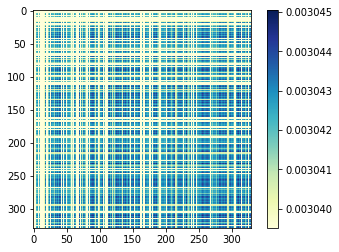

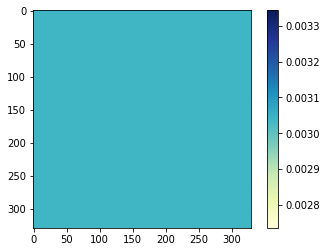

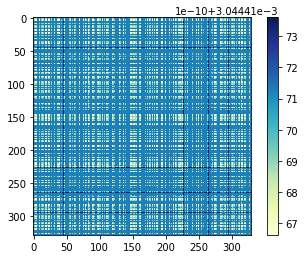

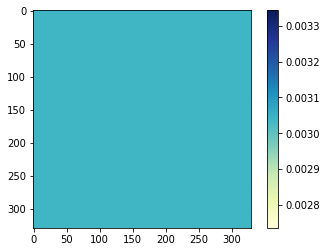

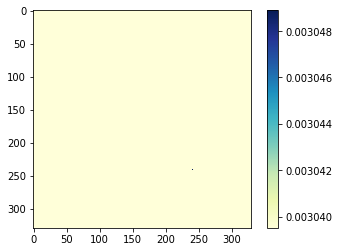

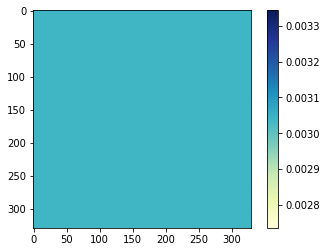

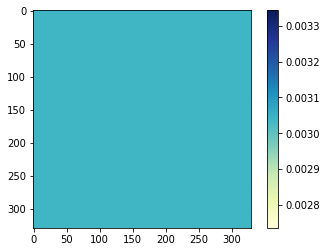

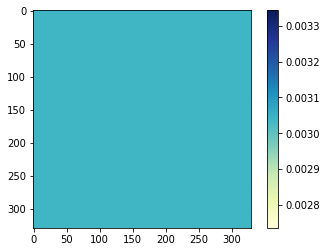

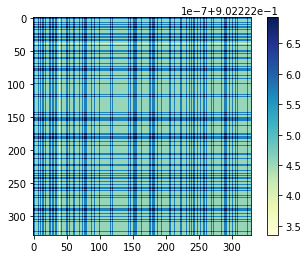

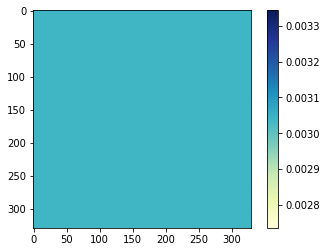

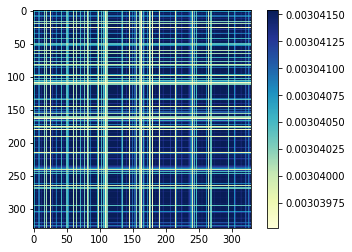

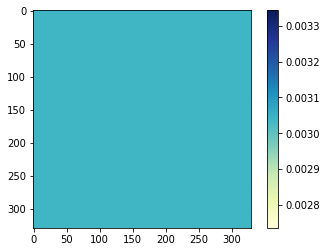

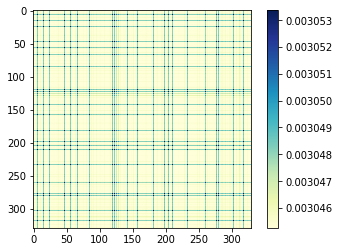

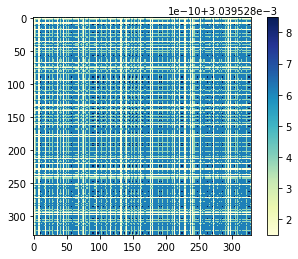

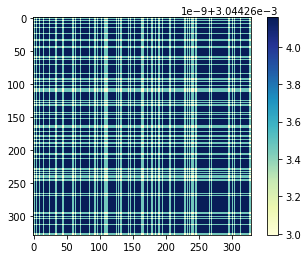

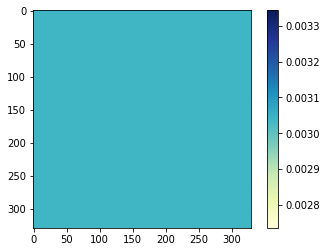

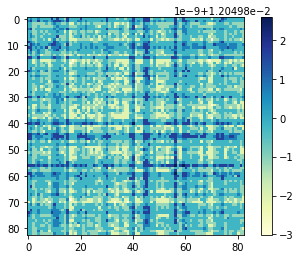

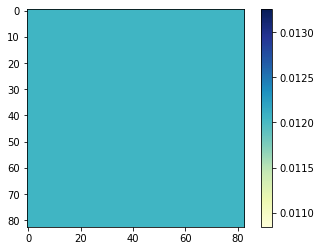

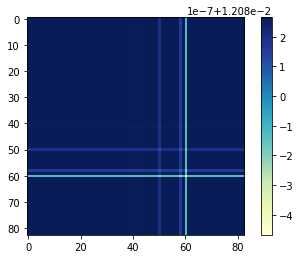

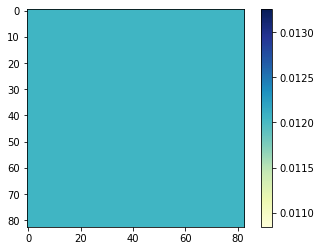

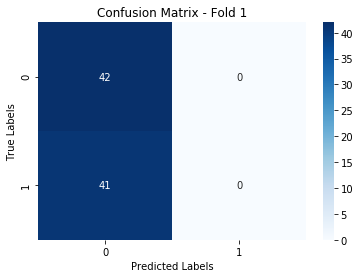

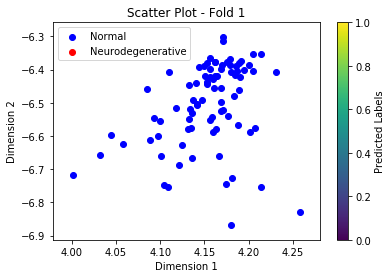

/home/jding/Documents/PD_contrastive_research_0817/utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  print('Precision:',TP / float(TP + FP))
/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no 

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.5060240963855421
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
Ending!!!------------------------------------------------------
(0.0, 1.0)
Loss: Contrastive_loss class_name Dag Accuracy: 0.5060240963855421
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        42
           1       0.00      0.00      0.00        41

    accuracy                           0.51        83
   macro avg       0.25      0.50      0.34        83
weighted avg       0.26      0.51      0.34        83

ARI: 0.0
acc: 0.5060240963855421 precision: nan recall: 0.0 fscore: 0.0 sensitivity: 0.0 specificity: 1.0 nmi 1.922257186801058e-15 ari 0.0
Fold 2/5:












  1%|          | 2/300 [00:00<00:35,  8.28it/s]









  1%|          | 3/300 [00:00<00:39,  7.59it/s]









  1%|▏         | 4/300 [00:00<00:41,  7.18it/s]









  2%|▏         | 5/300 [00:00<00:42,  6.90it/s]









  2%|▏         | 6/300 [00:00<00:43,  6.70it/s]









  2%|▏         | 7/300 [00:01<00:44,  6.56it/s]









  3%|▎         | 8/300 [00:01<00:45,  6.48it/s]









  3%|▎         | 9/300 [00:01<00:45,  6.42it/s]









  3%|▎         | 10/300 [00:01<00:45,  6.41it/s]









  4%|▎         | 11/300 [00:01<00:45,  6.39it/s]









  4%|▍         | 12/300 [00:01<00:45,  6.39it/s]









  4%|▍         | 13/300 [00:02<00:44,  6.39it/s]









  5%|▍         | 14/300 [00:02<00:45,  6.35it/s]









  5%|▌         | 15/300 [00:02<00:45,  6.32it/s]









  5%|▌         | 16/300 [00:02<00:45,  6.31it/s]









  6%|▌         | 17/300 [00:02<00:44,  6.30it/s]









  6%|▌         | 18/300 [00:02<00:44,  6.30it/s]









  6%|▋      

50
50
50
50












 17%|█▋        | 51/300 [00:08<00:50,  4.92it/s]









 17%|█▋        | 52/300 [00:08<00:47,  5.27it/s]









 18%|█▊        | 53/300 [00:08<00:44,  5.55it/s]









 18%|█▊        | 54/300 [00:08<00:42,  5.78it/s]









 18%|█▊        | 55/300 [00:08<00:41,  5.95it/s]









 19%|█▊        | 56/300 [00:08<00:40,  6.07it/s]









 19%|█▉        | 57/300 [00:09<00:39,  6.16it/s]









 19%|█▉        | 58/300 [00:09<00:38,  6.23it/s]









 20%|█▉        | 59/300 [00:09<00:38,  6.25it/s]









 20%|██        | 60/300 [00:09<00:38,  6.26it/s]









 20%|██        | 61/300 [00:09<00:38,  6.28it/s]









 21%|██        | 62/300 [00:09<00:37,  6.28it/s]









 21%|██        | 63/300 [00:10<00:37,  6.29it/s]









 21%|██▏       | 64/300 [00:10<00:37,  6.31it/s]









 22%|██▏       | 65/300 [00:10<00:37,  6.31it/s]









 22%|██▏       | 66/300 [00:10<00:36,  6.32it/s]









 22%|██▏       | 67/300 [00:10<00:36,  6.34it/s]









 23%

100
100












 34%|███▎      | 101/300 [00:16<00:48,  4.13it/s]

100
100












 34%|███▍      | 102/300 [00:16<00:43,  4.60it/s]









 34%|███▍      | 103/300 [00:16<00:39,  5.02it/s]









 35%|███▍      | 104/300 [00:16<00:36,  5.37it/s]









 35%|███▌      | 105/300 [00:16<00:34,  5.64it/s]









 35%|███▌      | 106/300 [00:17<00:33,  5.84it/s]









 36%|███▌      | 107/300 [00:17<00:32,  5.99it/s]









 36%|███▌      | 108/300 [00:17<00:31,  6.10it/s]









 36%|███▋      | 109/300 [00:17<00:30,  6.19it/s]









 37%|███▋      | 110/300 [00:17<00:30,  6.25it/s]









 37%|███▋      | 111/300 [00:17<00:30,  6.27it/s]









 37%|███▋      | 112/300 [00:18<00:30,  6.27it/s]









 38%|███▊      | 113/300 [00:18<00:29,  6.28it/s]









 38%|███▊      | 114/300 [00:18<00:29,  6.31it/s]









 38%|███▊      | 115/300 [00:18<00:29,  6.33it/s]









 39%|███▊      | 116/300 [00:18<00:29,  6.32it/s]









 39%|███▉      | 117/300 [00:18<00:29,  6.31it/s]









 39%|███▉      | 118/300 [00:19<00:28,  6.30it

 65%|██████▍   | 194/300 [00:31<00:16,  6.29it/s]









 65%|██████▌   | 195/300 [00:31<00:16,  6.30it/s]









 65%|██████▌   | 196/300 [00:31<00:16,  6.31it/s]









 66%|██████▌   | 197/300 [00:31<00:16,  6.31it/s]









 66%|██████▌   | 198/300 [00:31<00:16,  6.30it/s]









 66%|██████▋   | 199/300 [00:31<00:16,  6.29it/s]









 67%|██████▋   | 200/300 [00:31<00:15,  6.29it/s]

200
200
200
200












 67%|██████▋   | 201/300 [00:32<00:20,  4.93it/s]









 67%|██████▋   | 202/300 [00:32<00:18,  5.27it/s]









 68%|██████▊   | 203/300 [00:32<00:17,  5.54it/s]









 68%|██████▊   | 204/300 [00:32<00:16,  5.74it/s]









 68%|██████▊   | 205/300 [00:32<00:16,  5.89it/s]









 69%|██████▊   | 206/300 [00:33<00:15,  6.01it/s]









 69%|██████▉   | 207/300 [00:33<00:15,  6.08it/s]









 69%|██████▉   | 208/300 [00:33<00:14,  6.15it/s]









 70%|██████▉   | 209/300 [00:33<00:14,  6.18it/s]









 70%|███████   | 210/300 [00:33<00:14,  6.22it/s]









 70%|███████   | 211/300 [00:33<00:14,  6.24it/s]









 71%|███████   | 212/300 [00:34<00:14,  6.25it/s]









 71%|███████   | 213/300 [00:34<00:13,  6.24it/s]









 71%|███████▏  | 214/300 [00:34<00:13,  6.25it/s]









 72%|███████▏  | 215/300 [00:34<00:13,  6.26it/s]









 72%|███████▏  | 216/300 [00:34<00:13,  6.26it/s]









 72%|███████▏  | 217/300 [00:34<00:13,  6.28it

 98%|█████████▊| 293/300 [00:46<00:01,  6.29it/s]









 98%|█████████▊| 294/300 [00:47<00:00,  6.30it/s]









 98%|█████████▊| 295/300 [00:47<00:00,  6.30it/s]









 99%|█████████▊| 296/300 [00:47<00:00,  6.30it/s]









 99%|█████████▉| 297/300 [00:47<00:00,  6.31it/s]









 99%|█████████▉| 298/300 [00:47<00:00,  6.31it/s]









100%|█████████▉| 299/300 [00:47<00:00,  6.31it/s]

299
299
299
299












100%|██████████| 300/300 [00:48<00:00,  6.23it/s]


299
299
299
299


/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


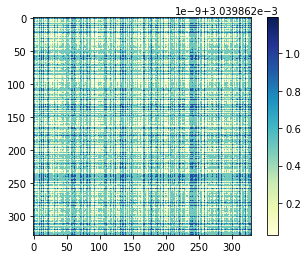

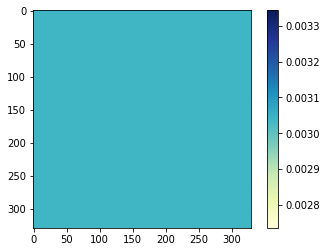

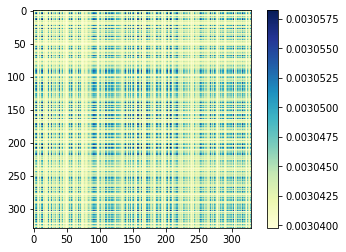

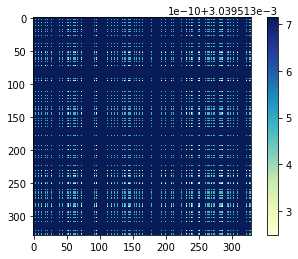

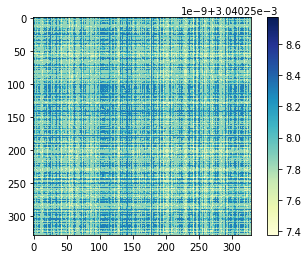

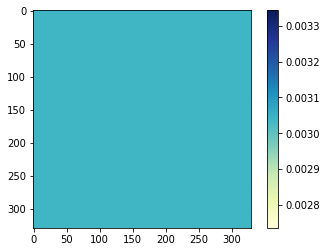

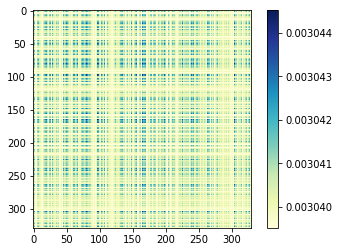

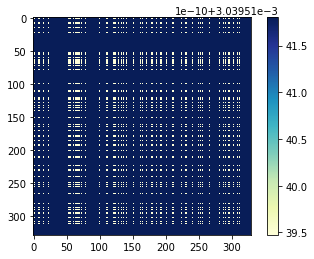

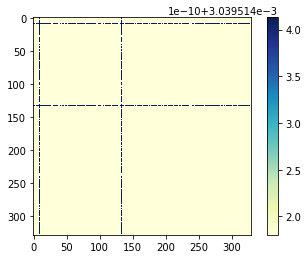

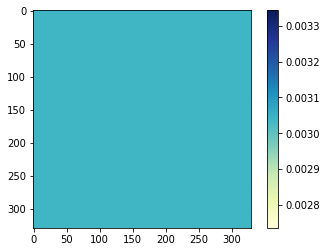

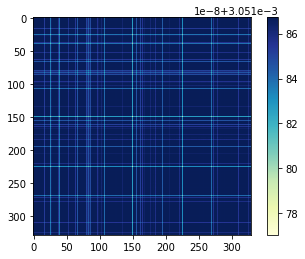

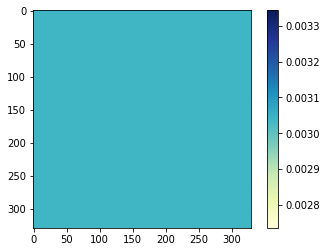

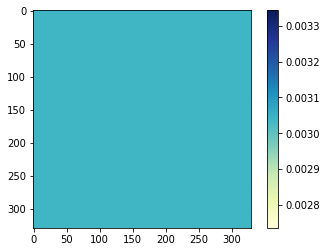

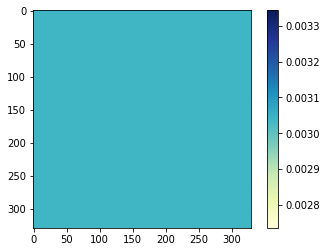

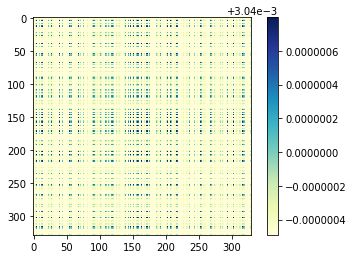

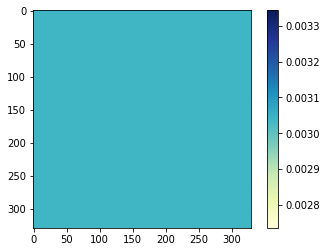

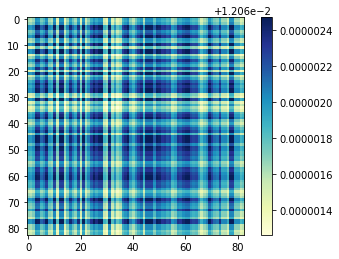

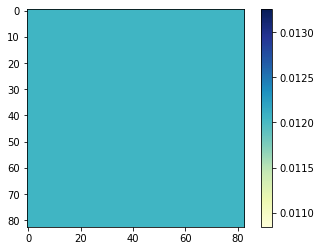

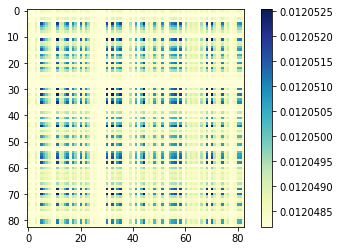

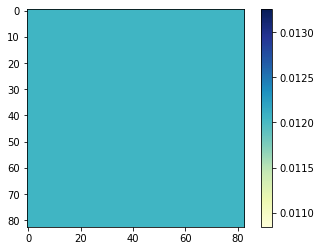

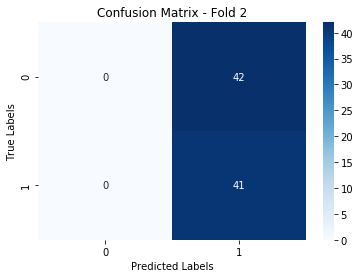

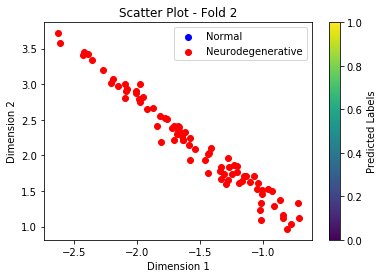

/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jding/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))










  0%|          | 0/300 [

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.4939759036144578
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.4939759036144578
Ending!!!------------------------------------------------------
(1.0, 0.0)
Loss: Contrastive_loss class_name Dag Accuracy: 0.4939759036144578
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.49      1.00      0.66        41

    accuracy                           0.49        83
   macro avg       0.25      0.50      0.33        83
weighted avg       0.24      0.49      0.33        83

ARI: 0.0
acc: 0.4939759036144578 precision: 0.4939759036144578 recall: 1.0 fscore: 0.6612903225806451 sensitivity: 1.0 specificity: 0.0 nmi 1.922257186801058e-15 ari 0.0
Fold 3/5:












  1%|          | 2/300 [00:00<00:36,  8.27it/s]









  1%|          | 3/300 [00:00<00:39,  7.55it/s]









  1%|▏         | 4/300 [00:00<00:41,  7.13it/s]









  2%|▏         | 5/300 [00:00<00:43,  6.85it/s]









  2%|▏         | 6/300 [00:00<00:43,  6.69it/s]









  2%|▏         | 7/300 [00:01<00:44,  6.59it/s]









  3%|▎         | 8/300 [00:01<00:44,  6.52it/s]









  3%|▎         | 9/300 [00:01<00:45,  6.45it/s]









  3%|▎         | 10/300 [00:01<00:45,  6.40it/s]









  4%|▎         | 11/300 [00:01<00:45,  6.38it/s]









  4%|▍         | 12/300 [00:01<00:45,  6.38it/s]









  4%|▍         | 13/300 [00:02<00:44,  6.38it/s]









  5%|▍         | 14/300 [00:02<00:44,  6.36it/s]









  5%|▌         | 15/300 [00:02<00:45,  6.33it/s]









  5%|▌         | 16/300 [00:02<00:44,  6.34it/s]









  6%|▌         | 17/300 [00:02<00:44,  6.34it/s]









  6%|▌         | 18/300 [00:02<00:44,  6.35it/s]









  6%|▋      

50
50
50
50












 17%|█▋        | 51/300 [00:08<00:50,  4.94it/s]

KeyboardInterrupt: 

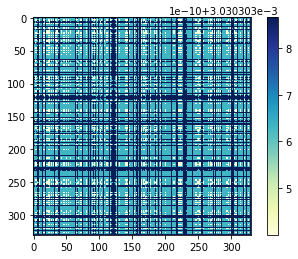

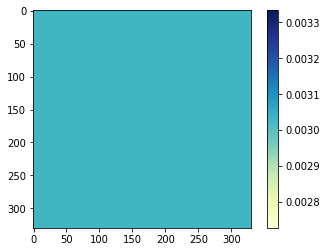

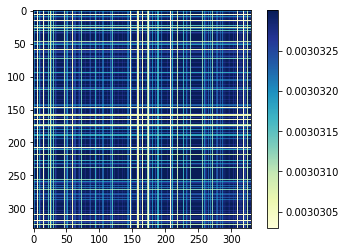

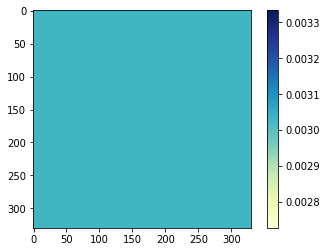

In [23]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    num_features = model_net.fc.in_features #512 # Resnet
#     num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    model_net.fc = model_net.fc.to(device) #512 # Resnet
#     model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    
    image_data_train_list, feature_data_train_list, adj_train_img_list, \
    adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
    adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list = dataloader_cv(datadir,skin_type, num_folds=5)
 
#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID

    for fold in range(len(image_data_train_list)):
        print(f"Fold {fold + 1}/{len(image_data_train_list)}:")
        
        image_data_train = image_data_train_list[fold]
        feature_data_train = feature_data_train_list[fold]
        adj_train_img = adj_train_img_list[fold]
        adj_f_knn_train = adj_f_knn_train_list[fold]
        image_data_test = image_data_test_list[fold]
        test_feature_data = test_feature_data_list[fold]
        adj_test_img = adj_test_img_list[fold]
        adj_f_knn_test = adj_f_knn_test_list[fold]
        
        y_train = y_train_list[fold]
        y_test = y_test_list[fold]
     
        image_data_train = image_data_train.to(torch.float32).to(device)
        feature_data_train = feature_data_train.to(torch.float32).to(device)
        # import pdb;pdb.set_trace()
        adj_train_img = adj_train_img.to(torch.float32).to(device)
        adj_f_knn_train = adj_f_knn_train.to(torch.float32).to(device)
        image_data_test = image_data_test.to(torch.float32).to(device)
        test_feature_data = test_feature_data.to(torch.float32).to(device)
        adj_test_img = adj_test_img.to(torch.float32).to(device)
        adj_f_knn_test = adj_f_knn_test.to(torch.float32).to(device)

        # y_train = y_train.to(device)
        # y_test = y_test.to(device)
        
        # import pdb;pdb.set_trace()

       

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
#              criterion2 = contrastive_loss
            criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        
        
        
        n_epochs = epoch
        training_range = tqdm(range(n_epochs))

        for n_epoch in training_range:
            
            if datadir == 'skin':
                model = Model_SKIN(projection, model_net, n_classes).to(device)
            elif datadir == 'abide':
                model = Model_ABIDE(projection, model_net, n_classes).to(device)
            elif datadir == 'pd':
                
                projection = Projection(262, 3)
                model = Model_PD_Weight(projection, model_net, n_classes, n_epoch).to(device, dtype=torch.float32)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            
            
            
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            # image_data_train = image_data_train.to(device)
            # feature_data_train = feature_data_train.to(device)
            # adj_train_img = adj_train_img.to(device)
            # adj_f_knn_train = adj_f_knn_train.to(device)
            
            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train, n_epoch)
      
            
            y = torch.from_numpy(y_train).to(torch.int64).to(device)

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
#             image_data_test = image_data_test.to(device)
#             test_feature_data = test_feature_data.to(device)
#             adj_test_img = adj_test_img.to(device)
#             adj_f_knn_test = adj_f_knn_test.to(device)
            # import pdb;pdb.set_trace()
            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test, n_epoch )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
#             y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            y_test = torch.from_numpy(y_test).to(torch.int64).to(device)
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
#             import pdb;pdb.set_trace()
            
            false_positive_indices = np.where((y_test.cpu().numpy() == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test.cpu().numpy()  == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            
            plt.figure()

#             plt.figure(figsize=(8, 6))

            # 分別取出不同類別的資料
            normal_data = test_output[pred == 0].cpu().detach().numpy()
            neurodegenerative_data = test_output[pred == 1].cpu().detach().numpy()

            # 在散點圖上繪製兩個不同類別的資料點，並使用不同的顏色
            plt.scatter(normal_data[:, 0], normal_data[:, 1], c='blue', label='Normal')
            plt.scatter(neurodegenerative_data[:, 0], neurodegenerative_data[:, 1], c='red', label='Neurodegenerative')

            # 添加圖例
            plt.legend()

            plt.colorbar(label='Predicted Labels')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.title(f'Scatter Plot - Fold {fold + 1}')
            plt.show()



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')
    
    result_data = {
        'FalsePositives': false_positives,
        'FalseNegatives': false_negatives
    }

        
    # 存储 False Positives 和 False Negatives 到 JSON 文件

#     with open('false_samples.json', 'w') as json_file:
#         json.dump(result_data, json_file, indent=4)
    
#     datadir = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data/spect_img_a2'
    
#     target_false_positives_dir = '/home/jding/Documents/PD_contrastive_research_0817/saved_fig/target_false_positives'  # 指定目标文件夹
#     os.makedirs(target_false_positives_dir, exist_ok=True)
#     copy_images(datadir, target_false_positives_dir, false_positives)

#     # 复制 False Negatives 的影像到目标文件夹
#     target_false_negatives_dir = '/home/jding/Documents/PD_contrastive_research_0817/saved_fig/target_false_negatives'  # 指定目标文件夹
#     os.makedirs(target_false_negatives_dir, exist_ok=True)
#     copy_images(datadir, target_false_negatives_dir, false_negatives)


    
            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    ngpu= 1
#     os.environ['CUDA_VISIBLE_DEVICES'] ='0'
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    torch.cuda.set_device(0)
    print("驱动为：",device)
    print("GPU型号: ",torch.cuda.get_device_name(0))


    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'resnet_18'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


In [27]:
sim_epoch_1 = np.load('epoch_50_weight.npy')
sim_epoch_100 = np.load('epoch_100_weight.npy')
sim_epoch_300 = np.load('epoch_299_weight.npy')

In [39]:
sim_epoch_1

array([[1.2541982, 1.2526885, 1.2582184, ..., 1.2238578, 1.2219846,
        1.2401812],
       [1.2526885, 1.2511878, 1.2566848, ..., 1.2225282, 1.2206663,
        1.2387547],
       [1.2582184, 1.2566848, 1.2623022, ..., 1.2273982, 1.2254953,
        1.2439797],
       ...,
       [1.2238578, 1.2225282, 1.2273982, ..., 1.1971387, 1.1954892,
        1.2115139],
       [1.2219846, 1.2206663, 1.2254953, ..., 1.1954892, 1.1938534,
        1.209744 ],
       [1.2401812, 1.2387547, 1.2439797, ..., 1.2115139, 1.209744 ,
        1.2269372]], dtype=float32)

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [8]:
import seaborn as sns

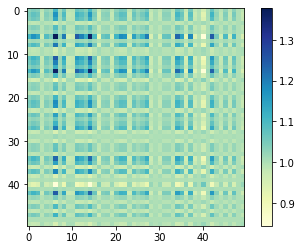

In [33]:
plt.imshow(sim_epoch_1[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

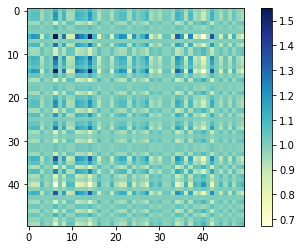

In [32]:
plt.imshow(sim_epoch_100[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

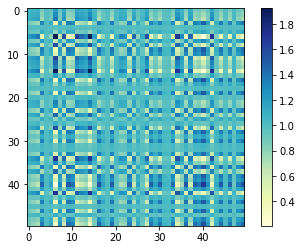

In [35]:
plt.imshow(sim_epoch_300[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

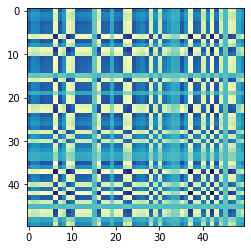

In [22]:
plt.imshow(sim_epoch_1[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

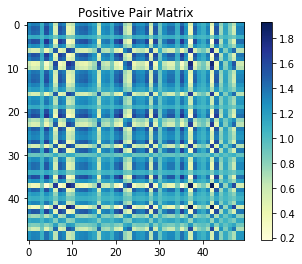

In [18]:
plt.imshow(sim_epoch_100[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

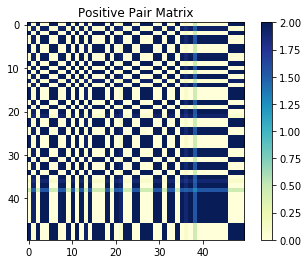

In [20]:
plt.imshow(sim_epoch_300[0:50,0:50], cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

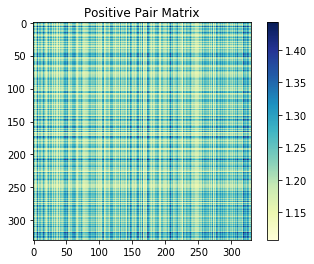

In [53]:
plt.imshow(sim_epoch_1, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

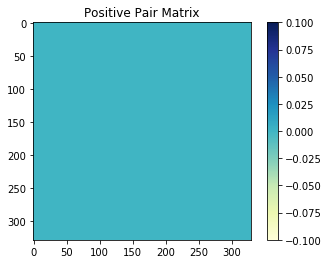

In [64]:
plt.imshow(sim_epoch_neg_1, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

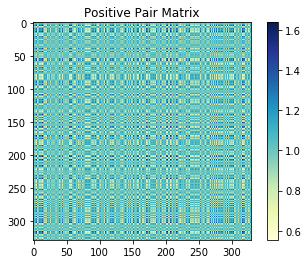

In [54]:
plt.imshow(sim_epoch_100, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

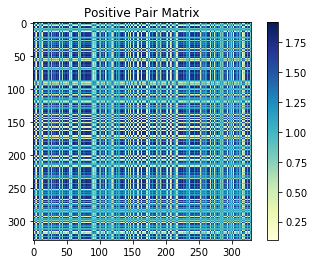

In [55]:
plt.imshow(sim_epoch_300,cmap='YlGnBu', interpolation='nearest')
plt.colorbar()

# 添加標籤和標題
# plt.xticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
# plt.yticks(range(len(sim_epoch_1)), range(1, len(sim_epoch_1) + 1))
plt.title('Positive Pair Matrix')

# 顯示圖像
plt.show()

In [6]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    # num_features = model_net.fc.in_features #512 # Resnet
    num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    # model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    # model_net.fc = model_net.fc.to(device) #512 # Resnet
    model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    
    image_data_train_list, feature_data_train_list, adj_train_img_list, \
    adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
    adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list = dataloader_cv(datadir,skin_type, num_folds=5)
 
#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID

    for fold in range(len(image_data_train_list)):
        print(f"Fold {fold + 1}/{len(image_data_train_list)}:")
        
        image_data_train = image_data_train_list[fold]
        feature_data_train = feature_data_train_list[fold]
        adj_train_img = adj_train_img_list[fold]
        adj_f_knn_train = adj_f_knn_train_list[fold]
        image_data_test = image_data_test_list[fold]
        test_feature_data = test_feature_data_list[fold]
        adj_test_img = adj_test_img_list[fold]
        adj_f_knn_test = adj_f_knn_test_list[fold]
        
        y_train = y_train_list[fold]
        y_test = y_test_list[fold]
     
        image_data_train = image_data_train.to(torch.float32).to(device)
        feature_data_train = feature_data_train.to(torch.float32).to(device)
        # import pdb;pdb.set_trace()
        adj_train_img = adj_train_img.to(torch.float32).to(device)
        adj_f_knn_train = adj_f_knn_train.to(torch.float32).to(device)
        image_data_test = image_data_test.to(torch.float32).to(device)
        test_feature_data = test_feature_data.to(torch.float32).to(device)
        adj_test_img = adj_test_img.to(torch.float32).to(device)
        adj_f_knn_test = adj_f_knn_test.to(torch.float32).to(device)

        # y_train = y_train.to(device)
        # y_test = y_test.to(device)
        
        # import pdb;pdb.set_trace()


        projection = Projection(262, 3)
        if datadir == 'skin':
            model = Model_SKIN(projection, model_net, n_classes).to(device)
        elif datadir == 'abide':
            model = Model_ABIDE(projection, model_net, n_classes).to(device)
        elif datadir == 'pd':
            model = Model_PD(projection, model_net, n_classes).to(device, dtype=torch.float32)

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
             criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        n_epochs = epoch

        training_range = tqdm(range(n_epochs))

        for epoch in training_range:
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            # image_data_train = image_data_train.to(device)
            # feature_data_train = feature_data_train.to(device)
            # adj_train_img = adj_train_img.to(device)
            # adj_f_knn_train = adj_f_knn_train.to(device)
            
            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
      
            
            y = torch.from_numpy(y_train).to(torch.int64).to(device)

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
#             image_data_test = image_data_test.to(device)
#             test_feature_data = test_feature_data.to(device)
#             adj_test_img = adj_test_img.to(device)
#             adj_f_knn_test = adj_f_knn_test.to(device)
            # import pdb;pdb.set_trace()
            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
#             y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            y_test = torch.from_numpy(y_test).to(torch.int64).to(device)
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
            
            false_positive_indices = np.where((y_test == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')

    # 存储 False Positives 和 False Negatives 到 JSON 文件
    result_data = {
        'FalsePositives': false_positives,
        'FalseNegatives': false_negatives
    }

    with open('false_samples.json', 'w') as json_file:
        json.dump(result_data, json_file, indent=4)
        
    # 存储 False Positives 和 False Negatives 到 JSON 文件

    with open('false_samples.json', 'w') as json_file:
        json.dump(result_data, json_file, indent=4)

    # 复制 False Positives 的影像到目标文件夹
    target_false_positives_dir = '/home/jding/Documents/PD_contrastive_research_0817/saved_fig/target_false_positives'  # 指定目标文件夹
    os.makedirs(target_false_positives_dir, exist_ok=True)
    copy_images(datadir, target_false_positives_dir, false_positives)

    # 复制 False Negatives 的影像到目标文件夹
    target_false_negatives_dir = '/home/jding/Documents/PD_contrastive_research_0817/saved_fig/target_false_nagatives'  # 指定目标文件夹
    os.makedirs(target_false_negatives_dir, exist_ok=True)
    copy_images(datadir, target_false_negatives_dir, false_negatives)


            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'densenet'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [62]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    # num_features = model_net.fc.in_features #512 # Resnet
    num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    # model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    # model_net.fc = model_net.fc.to(device) #512 # Resnet
    model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    y = torch.tensor(label_return(dataset_choice, class_name, "train")).to(device)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID
    import pdb;pdb.set_trace()
    for fold, (train_index, test_index) in enumerate(skf.split(image_data_train, y)):
        print(f"Fold {fold + 1}/{5}:")
        
        train_data, test_data = image_data_train[train_index], image_data_train[test_index]
        train_features, test_features = feature_data_train[train_index], feature_data_train[test_index]
        train_adj_img, test_adj_img = adj_train_img[train_index], adj_train_img[test_index]
        train_adj_f_knn, test_adj_f_knn = adj_f_knn_train[train_index], adj_f_knn_train[test_index]
        y_train, y_test = y[train_index], y[test_index]
    

#     

        projection = Projection(262, 3)
        if datadir == 'skin':
            model = Model_SKIN(projection, model_net, n_classes).to(device)
        elif datadir == 'abide':
            model = Model_ABIDE(projection, model_net, n_classes).to(device)
        elif datadir == 'pd':
            model = Model_PD(projection, model_net, n_classes).to(device)

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
             criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        n_epochs = epoch

        training_range = tqdm(range(n_epochs))

        for epoch in training_range:
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            image_data_train = image_data_train.to(device)
            feature_data_train = feature_data_train.to(device)
            adj_train_img = adj_train_img.to(device)
            adj_f_knn_train = adj_f_knn_train.to(device)

            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)

            

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
            image_data_test = image_data_test.to(device)
            test_feature_data = test_feature_data.to(device)
            adj_test_img = adj_test_img.to(device)
            adj_f_knn_test = adj_f_knn_test.to(device)

            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
            y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
            
            false_positive_indices = np.where((y_test == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')

    # 存储 False Positives 和 False Negatives 到 JSON 文件
    result_data = {
        'FalsePositives': false_positives,
        'FalseNegatives': false_negatives
    }

    with open('false_samples.json', 'w') as json_file:
        json.dump(result_data, json_file, indent=4)

            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'densenet'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


> <ipython-input-62-ac7c19ee4f6a>(43)train_eval()
-> for fold, (train_index, test_index) in enumerate(skf.split(image_data_train, y)):
(Pdb) y.dtype
torch.int64
(Pdb) q


BdbQuit: 

In [47]:
for fold, (false_positive_indices, false_negative_indices) in enumerate(zip(false_positives, false_negatives)):
        for i, idx in enumerate(false_positive_indices):
            image = Image.fromarray(test_data[idx])  # 从测试数据中获取图像
#             image.save(f'false_positives_fold{fold + 1}_sample{i + 1}.png')

#         for i, idx in enumerate(false_negative_indices):
#             image = Image.fromarray(test_data[idx])  # 从测试数据中获取图像
#             image.save(f'false_negatives_fold{fold + 1}_sample{i + 1}.png')

NameError: name 'false_positives' is not defined

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from torchvision import models
import torch.nn as nn
from sklearn.metrics import classification_report

# Define your model training and evaluation code here as 'train_eval' function

# def train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, epoch, n_classes):
    # Your existing training and evaluation code here...

# Define a function to perform k-fold cross-validation
img_data_dir = 'pd'
skin_type = 'dermatology_images'
losses_choice = 'Contrastive_loss'
model_select = 'densenet'
dataset_choice = 'pd'
category = 'your_category'  # 设置正确的类别值
n_epoch = 3
n_classes = 2

train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)

def k_fold_cross_validation(X, y, classifier_name, model, num_folds):
    conf_matrix = {}
    fig, ax = plt.subplots(figsize=(28, 5), nrows=1)
    
    print(f'Running {classifier_name} classification')

    k_accuracy = np.zeros((num_folds))
    conf_mat = np.zeros((2, 2))

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    cv = StratifiedKFold(n_splits=num_folds)
    for k, (train, test) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, epoch, n_classes)

        # Perform model training and evaluation for each fold
        # You may need to pass the appropriate data to the 'train_eval' function

        # Compute metrics and plot ROC curve for this fold

    # Calculate mean ROC and plot

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
            lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
    ax.legend(loc="lower right")

    conf_matrix[classifier_name] = conf_mat

    # Print cross-validated results
    print(f"{num_folds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5) * 100}%")
    print(k_accuracy)
    print()

    # Train the classifier with the full data

# Load your data (X and y) here
# X: observation x features matrix
# y: list of labels
# classifier_name: Name of your classifier (e.g., "ResNet-18")
# model: Your machine learning model

# Perform k-fold cross-validation
k_fold_cross_validation(X, y, model_select, model, num_folds)

# Plot and show ROC curve here
plt.show()


In [14]:
# !bash -c "/home/jding/Documents/PD_contrastive_research_0817/run_exp_pd.sh"